In [103]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,SubsetRandomSampler
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision.models import densenet169

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


In [27]:
torch.manual_seed(42)
np.random.seed(42)

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("🚀 Code Executed 🚀")

Using device: cuda
🚀 Code Executed 🚀


# Data Preparation and Exploration

In [ ]:
!wget -O FETAL_PLANES_ZENODO.zip https://zenodo.org/record/3904280/files/FETAL_PLANES_ZENODO.zip?download=1
!unzip FETAL_PLANES_ZENODO.zip -d fetal_planes_zenodo

print("🚀 Code Executed 🚀")

In [31]:
dataset_zip_path = '/kaggle/working/FETAL_PLANES_ZENODO.zip'
if os.path.exists(dataset_zip_path):
    os.remove(dataset_zip_path)
    
print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


In [57]:
image_dir = '/kaggle/working/fetal_planes_zenodo/Images'

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


## Load the data

In [32]:
df = pd.read_csv('/kaggle/working/fetal_planes_zenodo/FETAL_PLANES_DB_data.csv', delimiter=';')
df = df.rename(columns={'Train ': 'Train'})

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


## Display basic information about the dataset

In [33]:
print(df.info())
print(df.head())

print("🚀 Code Executed 🚀")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12400 entries, 0 to 12399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image_name   12400 non-null  object
 1   Patient_num  12400 non-null  int64 
 2   Plane        12400 non-null  object
 3   Brain_plane  12400 non-null  object
 4   Operator     12400 non-null  object
 5   US_Machine   12400 non-null  object
 6   Train        12400 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 678.2+ KB
None
                    Image_name  Patient_num  Plane  Brain_plane Operator  \
0  Patient00001_Plane1_1_of_15            1  Other  Not A Brain    Other   
1  Patient00001_Plane1_2_of_15            1  Other  Not A Brain    Other   
2  Patient00001_Plane1_3_of_15            1  Other  Not A Brain    Other   
3  Patient00001_Plane1_4_of_15            1  Other  Not A Brain    Other   
4  Patient00001_Plane1_5_of_15            1  Other  Not A Brain    Other   

  US_Mach

## Analyze class distribution

In [34]:
print("\nClass Distribution:")
print(df['Plane'].value_counts(normalize=True))

print("🚀 Code Executed 🚀")


Class Distribution:
Plane
Other              0.339758
Fetal brain        0.249355
Fetal thorax       0.138548
Maternal cervix    0.131129
Fetal femur        0.083871
Fetal abdomen      0.057339
Name: proportion, dtype: float64
🚀 Code Executed 🚀


In [35]:
print("\nBrain Subclass Distribution:")
print(df['Brain_plane'].value_counts(normalize=True))

print("🚀 Code Executed 🚀")


Brain Subclass Distribution:
Brain_plane
Not A Brain          0.750645
Trans-thalamic       0.132097
Trans-cerebellum     0.057581
Trans-ventricular    0.048145
Other                0.011532
Name: proportion, dtype: float64
🚀 Code Executed 🚀


## Encode labels

In [36]:
le_plane = LabelEncoder()
le_brain = LabelEncoder()
df['Plane_encoded'] = le_plane.fit_transform(df['Plane'])
df['Brain_plane_encoded'] = le_brain.fit_transform(df['Brain_plane'])

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


## Split the data

In [91]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Plane'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['Plane'], random_state=42)

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


## Visualize class distribution

🚀 Code Executed 🚀


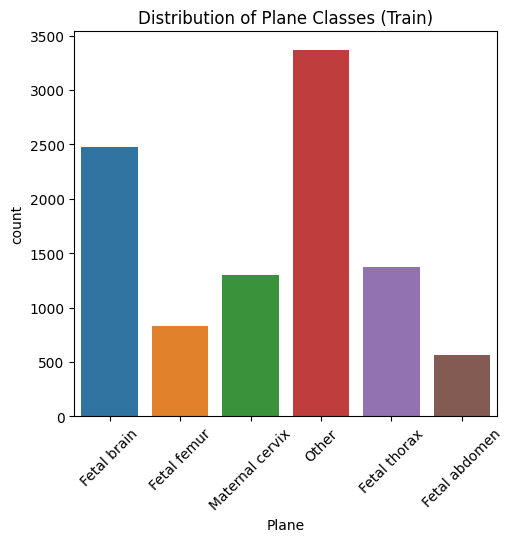

In [38]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Plane', data=train_df)
plt.title('Distribution of Plane Classes (Train)')
plt.xticks(rotation=45)

print("🚀 Code Executed 🚀")

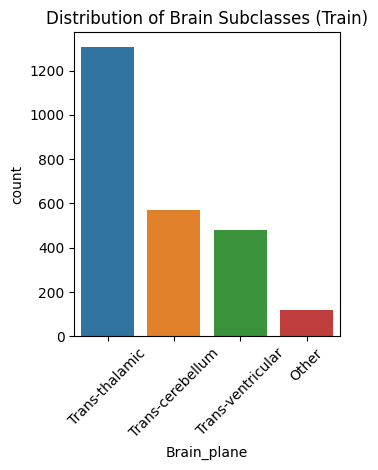

🚀 Code Executed 🚀


In [39]:
plt.subplot(1, 2, 2)
sns.countplot(x='Brain_plane', data=train_df[train_df['Plane'] == 'Fetal brain'])
plt.title('Distribution of Brain Subclasses (Train)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("🚀 Code Executed 🚀")

# Dataset and DataLoader

In [81]:
class FetalPlanesDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image_name'] + '.png'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')
        
        plane_label = self.dataframe.iloc[idx]['Plane_encoded']
        brain_label = self.dataframe.iloc[idx]['Brain_plane_encoded']
        
        if self.transform:
            image = self.transform(image)
        
        return image, plane_label, brain_label
    
print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


## Define transforms

In [82]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


## Create datasets

In [93]:
train_dataset = FetalPlanesDataset(train_df, image_dir, transform=train_transform)
val_dataset = FetalPlanesDataset(val_df, image_dir, transform=test_transform)
test_dataset = FetalPlanesDataset(test_df, image_dir, transform=test_transform)

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


## Create dataloaders

In [94]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


# Model Architecture

In [85]:
class FetalPlanesModel(nn.Module):
    def __init__(self, num_plane_classes, num_brain_classes):
        super(FetalPlanesModel, self).__init__()
        
        self.backbone = models.densenet169(pretrained=True)
        self.backbone.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        
        self.plane_classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_plane_classes)
        )
        
        self.brain_classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_brain_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        plane_output = self.plane_classifier(features)
        brain_output = self.brain_classifier(features)
        return plane_output, brain_output

model = FetalPlanesModel(num_plane_classes, num_brain_classes).to(device)
    
print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


## Create the model

In [86]:
num_plane_classes = len(le_plane.classes_)
num_brain_classes = len(le_brain.classes_)
model = FetalPlanesModel(num_plane_classes, num_brain_classes)
model = model.to(device)

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


# Loss Function and Optimizer

In [87]:
class HierarchicalLoss(nn.Module):
    def __init__(self, plane_weight=1.0, brain_weight=0.5):
        super(HierarchicalLoss, self).__init__()
        self.plane_loss = nn.CrossEntropyLoss()
        self.brain_loss = nn.CrossEntropyLoss()
        self.plane_weight = plane_weight
        self.brain_weight = brain_weight

    def forward(self, plane_output, brain_output, plane_target, brain_target):
        plane_loss = self.plane_loss(plane_output, plane_target)
        
        brain_mask = (plane_target == le_plane.transform(['Fetal brain'])[0])
        if brain_mask.sum() > 0:
            brain_loss = self.brain_loss(brain_output[brain_mask], brain_target[brain_mask])
        else:
            brain_loss = torch.tensor(0.0).to(plane_output.device)
        
        return self.plane_weight * plane_loss + self.brain_weight * brain_loss
    
print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


## Define loss and optimizer

In [88]:
criterion = HierarchicalLoss(plane_weight=1.0, brain_weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


# Training and Evaluation Functions

In [95]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    plane_correct = 0
    brain_correct = 0
    total = 0
    brain_total = 0
    
    for inputs, plane_labels, brain_labels in dataloader:
        inputs, plane_labels, brain_labels = inputs.to(device), plane_labels.to(device), brain_labels.to(device)
        
        optimizer.zero_grad()
        plane_outputs, brain_outputs = model(inputs)
        loss = criterion(plane_outputs, brain_outputs, plane_labels, brain_labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, plane_predicted = torch.max(plane_outputs, 1)
        _, brain_predicted = torch.max(brain_outputs, 1)
        
        total += plane_labels.size(0)
        plane_correct += (plane_predicted == plane_labels).sum().item()
        
        brain_mask = (plane_labels == le_plane.transform(['Fetal brain'])[0])
        brain_total += brain_mask.sum().item()
        brain_correct += (brain_predicted[brain_mask] == brain_labels[brain_mask]).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    plane_acc = plane_correct / total
    brain_acc = brain_correct / brain_total if brain_total > 0 else 0
    
    return epoch_loss, plane_acc, brain_acc

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


In [96]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    plane_correct = 0
    brain_correct = 0
    total = 0
    brain_total = 0
    
    with torch.no_grad():
        for inputs, plane_labels, brain_labels in dataloader:
            inputs, plane_labels, brain_labels = inputs.to(device), plane_labels.to(device), brain_labels.to(device)
            
            plane_outputs, brain_outputs = model(inputs)
            loss = criterion(plane_outputs, brain_outputs, plane_labels, brain_labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, plane_predicted = torch.max(plane_outputs, 1)
            _, brain_predicted = torch.max(brain_outputs, 1)
            
            total += plane_labels.size(0)
            plane_correct += (plane_predicted == plane_labels).sum().item()
            
            brain_mask = (plane_labels == le_plane.transform(['Fetal brain'])[0])
            brain_total += brain_mask.sum().item()
            brain_correct += (brain_predicted[brain_mask] == brain_labels[brain_mask]).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    plane_acc = plane_correct / total
    brain_acc = brain_correct / brain_total if brain_total > 0 else 0
    
    return epoch_loss, plane_acc, brain_acc

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


# Training Loop

In [ ]:
num_epochs = 50
best_val_loss = float('inf')

print("🚀 Code Executed 🚀")

In [98]:
for epoch in range(num_epochs):
    train_loss, train_plane_acc, train_brain_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_plane_acc, val_brain_acc = evaluate(model, val_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Plane Acc: {train_plane_acc:.4f}, Train Brain Acc: {train_brain_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Plane Acc: {val_plane_acc:.4f}, Val Brain Acc: {val_brain_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print()

test_loss, test_plane_acc, test_brain_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Plane Acc: {test_plane_acc:.4f}, Test Brain Acc: {test_brain_acc:.4f}")

print("🚀 Code Executed 🚀")

Epoch 1/50
Train Loss: 0.7790, Train Plane Acc: 0.8789, Train Brain Acc: 0.6741
Val Loss: 0.7065, Val Plane Acc: 0.8916, Val Brain Acc: 0.7010

Epoch 2/50
Train Loss: 0.6850, Train Plane Acc: 0.8949, Train Brain Acc: 0.7211
Val Loss: 0.8804, Val Plane Acc: 0.8765, Val Brain Acc: 0.6222

Epoch 3/50
Train Loss: 0.6137, Train Plane Acc: 0.9017, Train Brain Acc: 0.7650
Val Loss: 0.6337, Val Plane Acc: 0.8947, Val Brain Acc: 0.7455

Epoch 4/50
Train Loss: 0.6169, Train Plane Acc: 0.9095, Train Brain Acc: 0.7665
Val Loss: 0.6116, Val Plane Acc: 0.9057, Val Brain Acc: 0.7636

Epoch 5/50
Train Loss: 0.5771, Train Plane Acc: 0.9146, Train Brain Acc: 0.7842
Val Loss: 0.6535, Val Plane Acc: 0.9103, Val Brain Acc: 0.7030

Epoch 6/50
Train Loss: 0.5531, Train Plane Acc: 0.9226, Train Brain Acc: 0.7837
Val Loss: 0.5766, Val Plane Acc: 0.9163, Val Brain Acc: 0.7556

Epoch 7/50
Train Loss: 0.5086, Train Plane Acc: 0.9255, Train Brain Acc: 0.8105
Val Loss: 0.5526, Val Plane Acc: 0.9380, Val Brain Acc: 

## Load best model and evaluate

In [119]:
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_plane_acc, test_brain_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Plane Acc: {test_plane_acc:.4f}, Test Brain Acc: {test_brain_acc:.4f}")

print("🚀 Code Executed 🚀")

Test Loss: 0.3882, Test Plane Acc: 0.9488, Test Brain Acc: 0.8317
🚀 Code Executed 🚀


# Get predictions

In [104]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_plane_preds = []
    all_plane_labels = []
    all_brain_preds = []
    all_brain_labels = []
    
    with torch.no_grad():
        for inputs, plane_labels, brain_labels in dataloader:
            inputs = inputs.to(device)
            plane_outputs, brain_outputs = model(inputs)
            _, plane_preds = torch.max(plane_outputs, 1)
            _, brain_preds = torch.max(brain_outputs, 1)
            
            all_plane_preds.extend(plane_preds.cpu().numpy())
            all_plane_labels.extend(plane_labels.numpy())
            all_brain_preds.extend(brain_preds.cpu().numpy())
            all_brain_labels.extend(brain_labels.numpy())
    
    return np.array(all_plane_preds), np.array(all_plane_labels), np.array(all_brain_preds), np.array(all_brain_labels)

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


In [105]:
plane_preds, plane_labels, brain_preds, brain_labels = get_predictions(model, test_loader, device)

print("🚀 Code Executed 🚀")

🚀 Code Executed 🚀


# Plane classification report

In [106]:
print("Plane Classification Report:")
print(classification_report(plane_labels, plane_preds, target_names=le_plane.classes_))

print("🚀 Code Executed 🚀")

Plane Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.90      0.95      0.92       142
    Fetal brain       0.99      0.99      0.99       618
    Fetal femur       0.83      0.95      0.88       208
   Fetal thorax       0.93      0.95      0.94       344
Maternal cervix       1.00      0.99      1.00       325
          Other       0.95      0.90      0.93       843

       accuracy                           0.95      2480
      macro avg       0.93      0.95      0.94      2480
   weighted avg       0.95      0.95      0.95      2480

🚀 Code Executed 🚀


# Brain classification report (only for brain images)

In [112]:
present_classes = [le_brain.classes_[i] for i in range(1, 5)]
print("\nBrain Classification Report:")
print(classification_report(brain_labels[brain_mask],brain_preds[brain_mask],target_names=present_classes))

print("🚀 Code Executed 🚀")


Brain Classification Report:
                   precision    recall  f1-score   support

            Other       0.53      0.33      0.41        24
 Trans-cerebellum       0.88      0.88      0.88       145
   Trans-thalamic       0.82      0.89      0.86       331
Trans-ventricular       0.86      0.70      0.77       118

         accuracy                           0.83       618
        macro avg       0.77      0.70      0.73       618
     weighted avg       0.83      0.83      0.83       618

🚀 Code Executed 🚀


In [113]:
print("Unique values in brain_labels:", np.unique(brain_labels[brain_mask]))
print("Unique values in brain_preds:", np.unique(brain_preds[brain_mask]))
print("Number of classes in le_brain:", len(le_brain.classes_))
print("Classes in le_brain:", le_brain.classes_)

print("🚀 Code Executed 🚀")

Unique values in brain_labels: [1 2 3 4]
Unique values in brain_preds: [1 2 3 4]
Number of classes in le_brain: 5
Classes in le_brain: ['Not A Brain' 'Other' 'Trans-cerebellum' 'Trans-thalamic'
 'Trans-ventricular']
🚀 Code Executed 🚀


# Confusion matrices

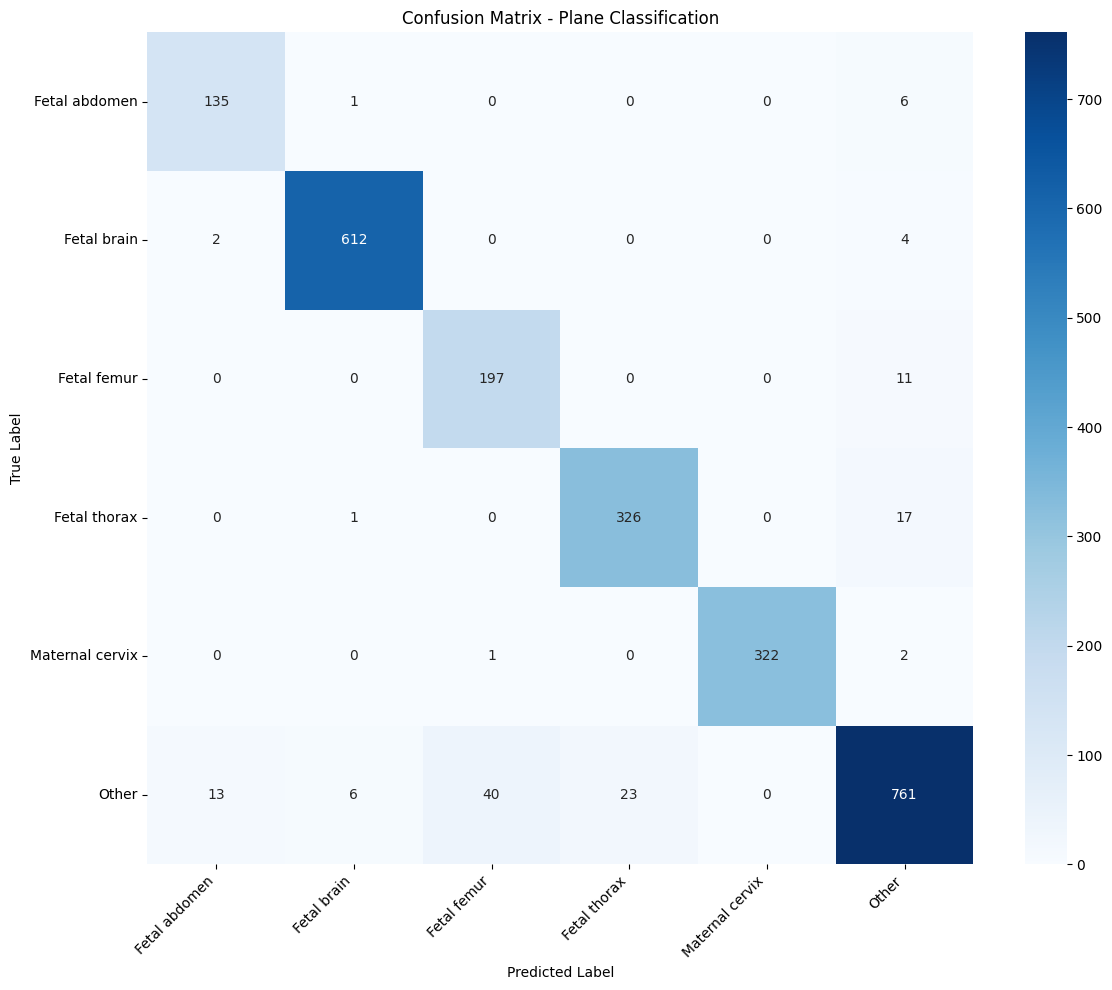

🚀 Code Executed 🚀


In [117]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(plane_labels, plane_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_plane.classes_,
            yticklabels=le_plane.classes_)
plt.title('Confusion Matrix - Plane Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("🚀 Code Executed 🚀")

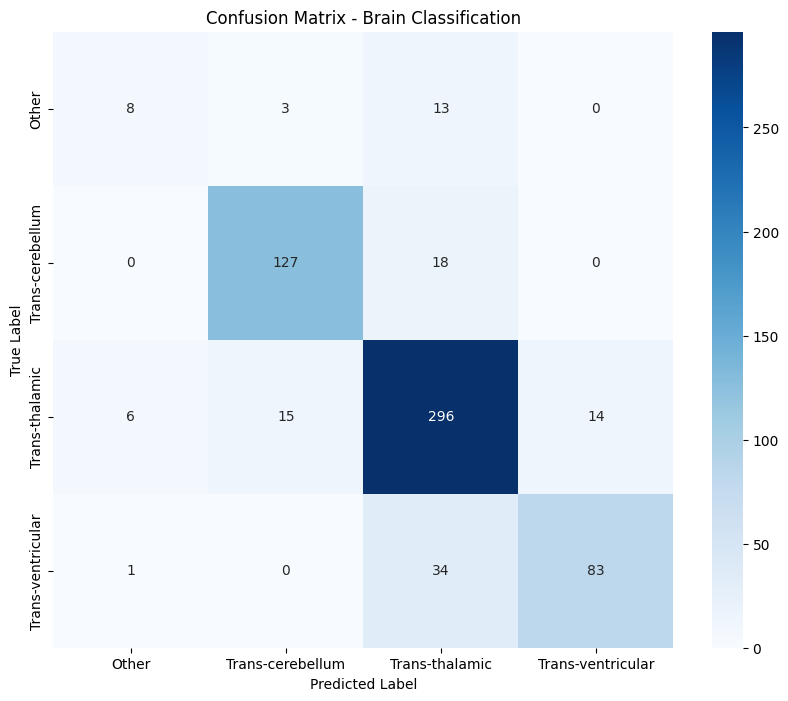

🚀 Code Executed 🚀


In [116]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(brain_labels[brain_mask], brain_preds[brain_mask])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=present_classes, yticklabels=present_classes)
plt.title('Confusion Matrix - Brain Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("🚀 Code Executed 🚀")

In [118]:
model.eval()
example_input = torch.randn(1, 1, 224, 224).to(device)
traced_model = torch.jit.trace(model, example_input)
torch.jit.save(traced_model, "fetal_planes_model.pt")
print("Model exported as fetal_planes_model.pt")

print("🚀 Code Executed 🚀")

Model exported as fetal_planes_model.pt
🚀 Code Executed 🚀
